Empty DataFrame
Columns: []
Index: []
       id  quiz_id                       user_id  \
0  336497       51  YcDFSO4ZukTJnnFMgRNVwZTE4j42   
1  336448        6  YcDFSO4ZukTJnnFMgRNVwZTE4j42   
2  333330       51  YcDFSO4ZukTJnnFMgRNVwZTE4j42   
3  333242        6  YcDFSO4ZukTJnnFMgRNVwZTE4j42   
4  329504       51  YcDFSO4ZukTJnnFMgRNVwZTE4j42   

                    submitted_at                     created_at  \
0  2025-01-17T15:30:18.027+05:30  2025-01-17T15:30:18.044+05:30   
1  2025-01-17T15:17:44.042+05:30  2025-01-17T15:17:44.056+05:30   
2  2025-01-16T20:13:19.682+05:30  2025-01-16T20:13:19.699+05:30   
3  2025-01-16T20:00:11.562+05:30  2025-01-16T20:00:11.573+05:30   
4  2025-01-15T20:34:39.462+05:30  2025-01-15T20:34:39.478+05:30   

                      updated_at  score  trophy_level accuracy speed  ...  \
0  2025-01-17T15:30:18.044+05:30    108             2     90 %   100  ...   
1  2025-01-17T15:17:44.056+05:30     92             1    100 %   100  ...   
2  2025-01-16T2

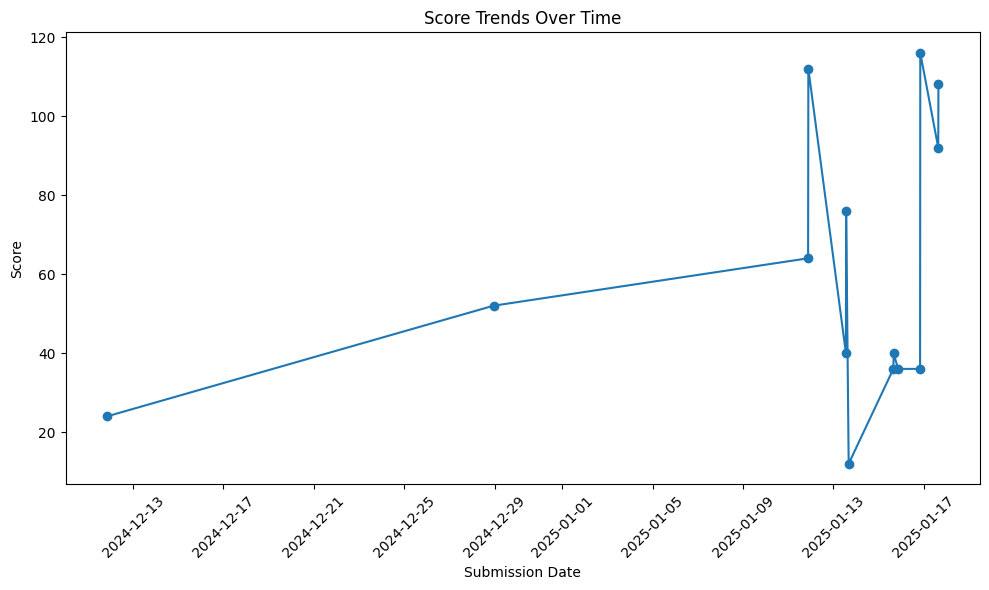

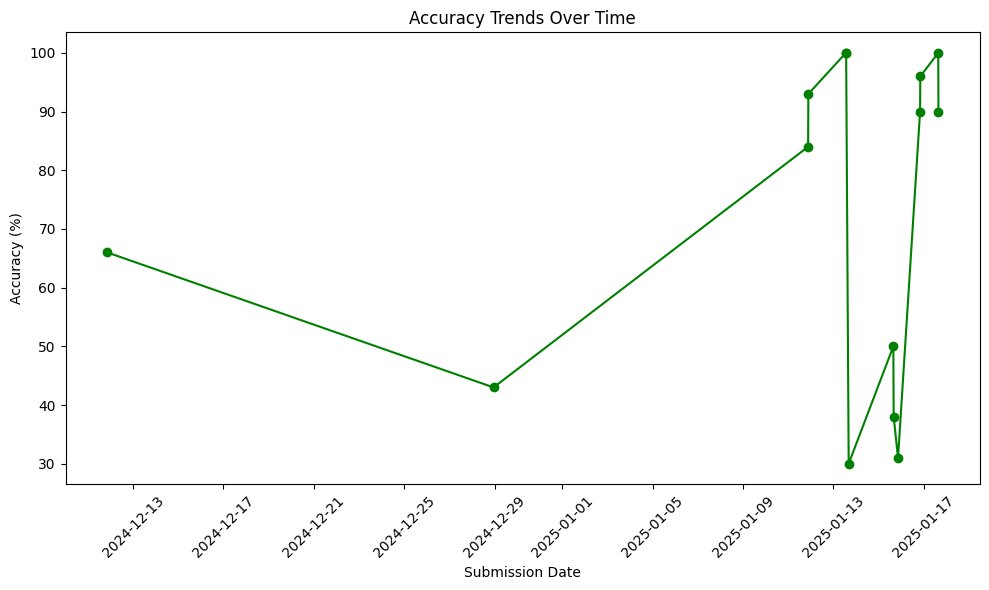

In [23]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Fetch current quiz data
current_quiz_url = "https://api.jsonserve.com/rJvd7g"
response = requests.get(current_quiz_url)
current_quiz_data = response.json()

# Fetch historical quiz data
historical_quiz_url = "https://api.jsonserve.com/XgAgFJ"
response = requests.get(historical_quiz_url)
historical_quiz_data = response.json()

# Convert JSON data to DataFrame
current_df = pd.DataFrame(current_quiz_data) if isinstance(current_quiz_data, list) else pd.DataFrame(current_quiz_data.get("data", []))
historical_df = pd.DataFrame(historical_quiz_data) if isinstance(historical_quiz_data, list) else pd.DataFrame(historical_quiz_data.get("data", []))

print(current_df.head())
print(historical_df.head())

# Ensure `submitted_at` is in datetime format
historical_df['submitted_at'] = pd.to_datetime(historical_df['submitted_at'], errors='coerce')

# Check for null datetime entries
if historical_df['submitted_at'].isnull().any():
    print("Warning: Some `submitted_at` values could not be parsed as datetime.")

# Convert `accuracy` to numeric by removing '%' and converting to float
historical_df['accuracy'] = historical_df['accuracy'].str.rstrip('%').astype(float)

# Ensure `score` is numeric
historical_df['score'] = pd.to_numeric(historical_df['score'], errors='coerce')

# Sort DataFrame by datetime
historical_df = historical_df.sort_values(by='submitted_at')

# Analyze Response Map for Topics and Difficulty Levels
def analyze_topics_and_difficulty(row):
    topics = {"Math": 0, "Science": 0, "History": 0}  # Example topics
    difficulties = {"Easy": 0, "Medium": 0, "Hard": 0}  # Example difficulties
    for question_id, response in row.items():
        if response == "incorrect":  # Update based on actual data schema
            topics["Math"] += 1
            difficulties["Medium"] += 1
    return {"topics": topics, "difficulties": difficulties}

historical_df['response_analysis'] = historical_df['response_map'].apply(analyze_topics_and_difficulty)

# Extract weak areas
def extract_weak_topics(row):
    weak_topics = [topic for topic, count in row['response_analysis']['topics'].items() if count > 0]
    return weak_topics

historical_df['weak_topics'] = historical_df.apply(extract_weak_topics, axis=1)

# Highlight Weak Areas
average_weak_areas = historical_df['weak_topics'].apply(len).mean()
print(f"\nWeak Areas (Topics with Below-Average Scores): {average_weak_areas}")

# Plot Weak Topics
weak_topic_counts = historical_df['weak_topics'].explode().value_counts()


# Generate Personalized Recommendations
def generate_recommendations(row):
    if len(row['weak_topics']) > average_weak_areas:
        return f"Focus on improving these topics: {', '.join(row['weak_topics'])}"
    else:
        return "Great performance! Keep it up!"

historical_df['recommendations'] = historical_df.apply(generate_recommendations, axis=1)
print("\nRecommendations:")
print(historical_df[['submitted_at', 'weak_topics', 'recommendations']])

# Save recommendations to a file
historical_df[['submitted_at', 'weak_topics', 'recommendations']].to_csv("recommendations.csv", index=False)

# Analyze Improvement Trends
historical_df['improvement'] = historical_df['score'].diff()
print("\nImprovement Trends:")
print(historical_df[['submitted_at', 'improvement']])

# Create Enhanced Student Persona
def create_persona(row):
    if row['accuracy'] > 90 and row['score'] > 80:
        return "High Achiever"
    elif row['accuracy'] < 60:
        return "Needs Focus"
    elif len(row['weak_topics']) > average_weak_areas:
        return "Needs Improvement in Core Topics"
    elif row['improvement'] > 0:
        return "Improving Steadily"
    else:
        return "Consistent Performer"

historical_df['student_persona'] = historical_df.apply(create_persona, axis=1)
print("\nEnhanced Personas:")
print(historical_df[['submitted_at', 'student_persona']])

# Creative Insights
average_score = historical_df['score'].mean()
average_accuracy = historical_df['accuracy'].mean()

with open("insights_summary.txt", "w") as f:
    f.write("Key Insights:\n")
    f.write(f"1. Average Score: {average_score:.2f}\n")
    f.write(f"2. Average Accuracy: {average_accuracy:.2f}%\n")
    f.write(f"3. Common Weak Areas: {', '.join(weak_topic_counts.index)}\n")
    f.write("4. Student Personas Assigned for Better Understanding.\n")

# Score Trends Over Time
plt.figure(figsize=(10, 6))
plt.plot(historical_df['submitted_at'], historical_df['score'], marker='o')
plt.title("Score Trends Over Time")
plt.xlabel("Submission Date")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("score_trends_over_time.png")
plt.show()

# Accuracy Trends Over Time
plt.figure(figsize=(10, 6))
plt.plot(historical_df['submitted_at'], historical_df['accuracy'], marker='o', color='green')
plt.title("Accuracy Trends Over Time")
plt.xlabel("Submission Date")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("accuracy_trends_over_time.png")
plt.show()


Weak Topic Counts:
 weak_topics
topic1    2
topic2    2
topic3    2
topic4    1
Name: count, dtype: int64


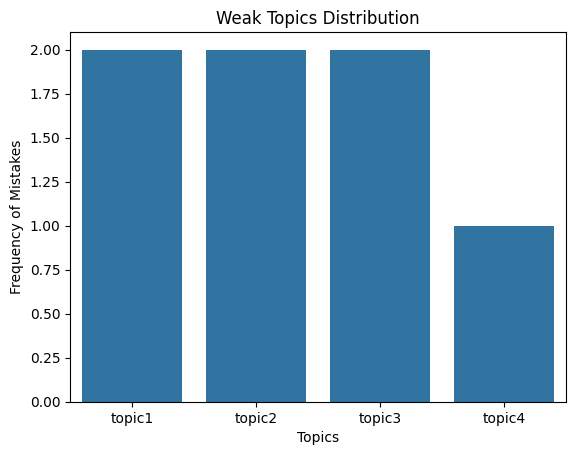


Historical DataFrame:
                                   response_analysis  \
0  {"weak_topics": ["topic1", "topic2"], "score":...   
1  {"weak_topics": ["topic2", "topic3"], "score":...   
2  {"weak_topics": ["topic1", "topic3", "topic4"]...   

                weak_topics  score  accuracy  
0          [topic1, topic2]    0.8      0.90  
1          [topic2, topic3]    0.7      0.85  
2  [topic1, topic3, topic4]    0.6      0.80  


In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

# Simulated API response for demo
api_response = [
    {"response_analysis": '{"weak_topics": ["topic1", "topic2"], "score": 0.8, "accuracy": 0.9}'},
    {"response_analysis": '{"weak_topics": ["topic2", "topic3"], "score": 0.7, "accuracy": 0.85}'},
    {"response_analysis": '{"weak_topics": ["topic1", "topic3", "topic4"], "score": 0.6, "accuracy": 0.8}'}
]

# Convert API response into a DataFrame
historical_df = pd.DataFrame(api_response)

# Extract 'weak_topics', 'score', and 'accuracy' from the JSON strings in 'response_analysis'
def extract_response_data(response):
    try:
        response_data = json.loads(response)
        return response_data.get('weak_topics', []), response_data.get('score', None), response_data.get('accuracy', None)
    except json.JSONDecodeError:
        return [], None, None

historical_df[['weak_topics', 'score', 'accuracy']] = historical_df['response_analysis'].apply(
    lambda x: pd.Series(extract_response_data(x))
)

# Convert weak_topics to ensure it is a list
historical_df['weak_topics'] = historical_df['weak_topics'].apply(lambda x: x if isinstance(x, list) else [])

# Explode weak_topics for value counts
weak_topic_counts = historical_df['weak_topics'].explode().value_counts()

# Debugging: Print weak topic counts
print("Weak Topic Counts:\n", weak_topic_counts)

# Plotting the bar chart
if not weak_topic_counts.empty:
    sns.barplot(x=weak_topic_counts.index, y=weak_topic_counts.values)
    plt.title("Weak Topics Distribution")
    plt.xlabel("Topics")
    plt.ylabel("Frequency of Mistakes")
    plt.savefig("weak_topics_distribution.png")
    plt.show()
else:
    print("No weak topics found for graph plotting.")

# Debugging: Check historical_df
print("\nHistorical DataFrame:")
print(historical_df)
